# Gesture Recognition


In [1]:
## Importing all the neccessary libraries for preprocessing the data

import numpy as np
import os
from skimage import io
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime
import os
import glob
import random
import cv2
import tensorflow as tf

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


### Stepwise Procedure for building and training the model
 1. Load the data
 2. Preprocess the data including resizing, normalizations, transformations, and handling missing values
 3. Data Generator to consolidate the data into batches and inputs for the model
 4. Model Genrerator which will use the data genrated above to run experiments
 5. Run Ablation Experiments to check the accuracy and validity of the model
 6. Run the model on whole Data

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
#experiment with the below parameters to improve the efficiency and performance of the model.
batch_size = 15
rows = 120   # X dimension of the image
columns = 120   # Y dimesnion of the image
#total_frames = 30
frames = 30  # lenght of the video frames
channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

## Preprocessing the data

Image 1 Shape:  (360, 360, 3)
Image 2 Shape:  (120, 160, 3)


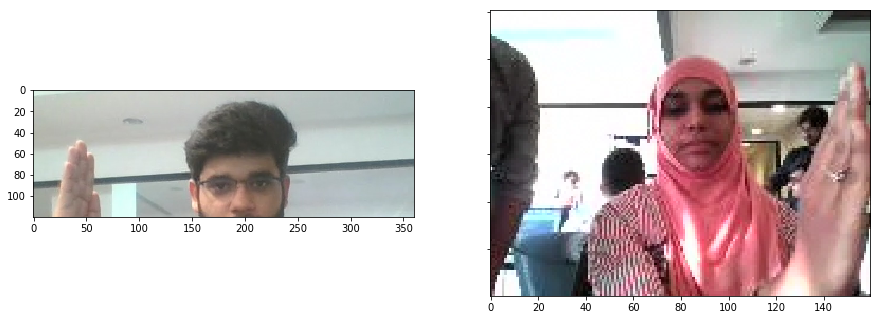

In [4]:
"""
In the preprocessing of data we will check if the images are of different sizes and 
will resize them to some common arbitrary values for experiment
""" 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,20))
f.set_figwidth(15)
#lets look at some random image using glob
Dataset_path = "Project_data/train"
Cls = ['WIN_20180907_15_35_09_Pro_Right Swipe_new','WIN_20180907_15_39_51_Pro_Stop Gesture_new','WIN_20180907_15_45_40_Pro_Left Swipe_new_Left Swipe_new','WIN_20180926_17_20_39_Pro_Right_Swipe_new']
image_path = os.path.join(Dataset_path, Cls[2],'*')
image_path = glob.glob(image_path)
rand_index = random.randint(0, len(image_path))
image = io.imread(image_path[rand_index])
ax1.imshow(image)
print("Image 1 Shape: ",image.shape)

image_path = os.path.join(Dataset_path, Cls[3],'*')
image_path = glob.glob(image_path)
rand_index = random.randint(0, len(image_path))
image2 = io.imread(image_path[rand_index])
ax2.imshow(image2)
print("Image 2 Shape: ",image2.shape)

### Normalisation

In [6]:
# Normalizing the images to remove any outliers in them using the percentile method
def normalize_data(img):
    return data/127.5-1

### Affine Transformation

In [7]:
#  function to generate a random affine transform on the imamge for data augmentation
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return M

## Data Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
# Helper function to initialize all the batch image data and labels
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size,frames,rows,columns,channel)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [9]:
def load_batch_images(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data,batch_labels = init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = init_batch_data(batch_size)
    
    # We will also build an augmented batch data with horizontal flip
    batch_data_flip,batch_labels_flip = init_batch_data(batch_size)
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0,frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        M = get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            ## image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes   
            resized = cv2.resize(image, (rows,columns), interpolation = cv2.INTER_AREA)
            #Normal data
            batch_data[folder,idx] = (resized)
            
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:

def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)


In [11]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 #experimenting with these
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input
from keras.layers import LSTM, Bidirectional, SimpleRNN, RNN
from keras.optimizers import Adam

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto',epsilon=0.0002)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Final model

In [16]:
# specifying all the major layers in our model
featuremap = [8,16,32,64,128]
dense = [256,128,5]

# Input
input_shape=(30,120,120,3)

model3d = Sequential()
#First hidden layer
model3d.add(Conv3D(featuremap[0], kernel_size=(3,3,3),input_shape=input_shape,padding='same', name="conv1"))

model3d.add(BatchNormalization())
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))

#Second hidden Layer
model3d.add(Conv3D(featuremap[1], kernel_size=(3,3,3),padding='same',name="conv2"))
model3d.add(BatchNormalization())
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))

#Third hidden Layer
model3d.add(Conv3D(featuremap[2], kernel_size=(3,3,3), padding='same',name="conv3"))
model3d.add(BatchNormalization())
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))

#Forth hidden Layer
model3d.add(Conv3D(featuremap[3], kernel_size=(1,3,3), padding='same',name="conv4"))
model3d.add(BatchNormalization())
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))

#Fifth hidden Layer
model3d.add(Conv3D(featuremap[4], kernel_size=(1,3,3), padding='same',name="conv5"))
model3d.add(Activation('relu'))
model3d.add(Dropout(0.25))
model3d.add(MaxPooling3D(pool_size=(1,1,1)))

model3d.add(Flatten())
#Adding Dense Layer
model3d.add(Dense(dense[0], activation='relu'))
model3d.add(Dropout(0.25))
model3d.add(Dense(dense[1], activation='relu'))
model3d.add(Dropout(0.25))

#softmax layer
model3d.add(Dense(dense[2], activation='softmax'))

In [17]:
# specifying the optimiser for our model
optimiser = Adam(0.0002)
model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [18]:
#fit the model
model_history = model3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                      validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, 
                      initial_epoch=0)

Source path =  Project_data/val ; batch size = 15
Source path =  Project_data/train ; batch size = 15
Epoch 1/20
45/45 [==============================] - 197s 4s/step - loss: 1.4926 - categorical_accuracy: 0.3362 - val_loss: 1.0682 - val_categorical_accuracy: 0.5967

Epoch 00001: saving model to model_init_2020-07-0110_36_36.009248/model-00001-1.49546-0.33233-1.06819-0.59667.h5
Epoch 2/20
45/45 [==============================] - 29s 639ms/step - loss: 1.3091 - categorical_accuracy: 0.4765 - val_loss: 1.0110 - val_categorical_accuracy: 0.6095

Epoch 00002: saving model to model_init_2020-07-0110_36_36.009248/model-00002-1.30909-0.47654-1.01104-0.60952.h5
Epoch 3/20
45/45 [==============================] - 32s 711ms/step - loss: 1.1888 - categorical_accuracy: 0.5185 - val_loss: 1.0229 - val_categorical_accuracy: 0.5476

Epoch 00003: saving model to model_init_2020-07-0110_36_36.009248/model-00003-1.18878-0.51852-1.02292-0.54762.h5
Epoch 4/20
45/45 [==============================] - 32s 7

In [19]:
# function to plot the accuracies and looses
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

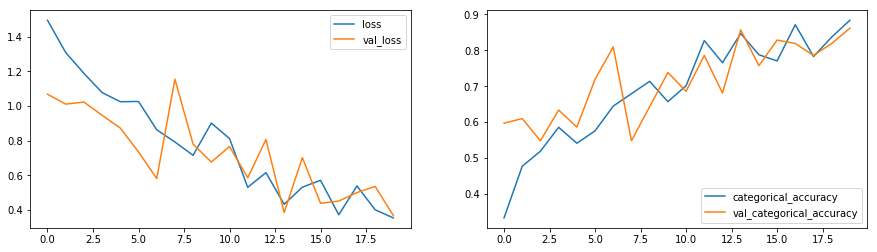

In [20]:
plot(model_history)